<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Introduction to Clustering and K-Means

_Authors: Tim Book (DC), Dave Yerrington (SF), Joseph Nelson (DC)_

---

![](https://snag.gy/kYWumd.jpg)

# Learning Objectives
*After this lesson, you will be able to:*
- Understand basic unsupervised clustering problems
- Perform a K-Means Clustering Analysis
- Evaluate clusters for fit 

## Lesson Guide
- [Unsupervised learning](#unsupervised)
- [Introduction to clustering](#intro)
- [Uses for Clustering](#uses)
- [What is clustering?](#what)
- [KNN review](#knn)
- [Clustering algorithms](#algos)
- [K-means clustering](#k-means)
- [K-Means step-by-step](#km-steps)
- [K-Means: a visual example](#vis)
- [K-Means caveats and pitfalls](#caveats)
- [Centroid Initialization](#init-centroid)
- [Choosing K](#choose-k)
- [A note on K-Means convergence](#converge)
- [K-Means in sklearn](#sklearn)
- [OPTIONAL: Understanding the objective function](#obj)
- [Metrics: inertia and the silhouette coefficient](#sil)
- [Practice: use K-Means on the "Isotopic Composition Plutonium Batches" data](#pluto)
    - [How does scaling affect fit?](#scaling)
- [Conclusion: K-Means tradeoffs](#conclusion)

<a id='unsupervised'></a>

## Unsupervised learning

---

Up until now, we've been doing **supervised learning** - that is, modeling of the form:

> Given X, predict Y

(THREAD) Supervised learning comes in two flavors: can you remind me what they are? And how are they different?


<details>
<summary>Definitions:</summary>

* Regression models predict a **continuous response** (numerical).
* Classification models predict a **discrete response** (categorical).
</details>

When we don't have a Y variable to predict, we are in the realm of **unsupervised learning**. Since there is no Y variable, unsupervised learning has no measurable "goal". Instead, unsupervised learning seeks to **represent the data in new ways**. Today we're introducing **clustering**; however, there are many other types of unsupervised learning.

> Data without a Y variable are sometimes referred to as **unlabeled** data. This is because the Y variable is often refered to as a **label**.

## New Issues
Since there is no Y variable to "supervise" our learning, unsupervised learning presents us with some new issues we've never had to work through:

* **What is "correct"?** Since there's no Y variable, we don't have an easy to way know if we're even doing a good job.
* **Tuning parameter selection.** Many unsupervised models have tuning parameters. How do we tune them if we don't know how to evaluate our model?
* **Unpredictability (clustering).** In clustering, it is very difficult to predict what our model will give us. It's possible that a clustering algorithm won't give us actionable results. More on this later.

<a name="intro"></a>
# Introduction to Clustering

---

**Clustering** is a task in which we seek to group our observations in **homogenous clusters**. Since it's unsupervised, it is up to us, the data scientists, to decide what we mean by "homogenous".

<a name="uses"></a>
## Uses for Clustering
### Marketing
Marketing teams do a lot of data-driven research into who does and does not buy their product (and why). As a marketing data scientist, you might collect demographic information about people in a survey and their spending habits. After clustering, you do some EDA and you might discover:

> People in Cluster A aren't buying our product, but people in Cluster B are. Why?

After some digging, you might make the conclusion and recommendation:

> People in Cluster A have characteristic X, but people in Cluster B do not. In order to sell to Cluster A, we should target our marketing with respect to X.

Maybe X = 
* They don't have cable
* Their political beliefs
* They live in cities


<img src="https://snag.gy/BdfATE.jpg" style="width: 500px">

### Political Polling
In the same vein as the above example, instead of buying a product, maybe it's **voting for a certain candidate**.

The popular data-drive journalism website FiveThirtyEight did a lot of research into the then-upcoming 2020 Democratic primaries. They have done some (subjective!) clustering techniques to divide Democratic voters into five clusters:

* Party Loyalists
* The Left
* Millennials and Friends
* Black voters
* Hispanic voters (sometimes in combination with Asian voters)

They then graded each candidate based on their favorability of these clusters:

![](./assets/imgs/five-corners.png)

Their methodology is more speculation than science, but it still provides a good example into how real political polling works. You can read more about it [here](https://fivethirtyeight.com/features/the-5-key-constituencies-of-the-2020-democratic-primary/).

_NOTE:_ Unlike the kinds of clustering we'll see in our class, someone might fall into multiple categories here.

## Recommender Systems
Online retailers cluster their items by similarity. If you buy (or search for) a few items in a given cluster, they may recommend you other similar items in that same cluster.

![](./assets/imgs/recs.png)

<img src="https://snag.gy/YUt5RO.jpg" style="float: left; margin-right: 25px; width: 250px">

## What other problems do you think can make use of clustering?

(THREAD)

<a name="algos"></a>
# Clustering algorithms 

---

The are many different algorithms that can perform clustering given a dataset. 

These algorithms nearly always reduce to difficult optimization problems which may converge on a local minimum (similarly to gradient descent).

- **K-Means** (mean centroids)
- **DBSCAN** (density based)
- **Hierarchical** (nested clusters by merging or splitting successively)
- **Affinity Propagation** (graph based approach to let points 'vote' on their preferred 'exemplar')
- **Mean Shift** (can find number of clusters)
- **Spectral Clustering**
- **Agglomerative Clustering** (suite of algorithms all based on applying the same criteria/characteristics of one cluster to others)


Image from scikit-learn: ["Comparing different clustering algorithms on toy datasets."](https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html)

![](./assets/imgs/sklearn-clustering.png)

From the above, note that $k$-Means clustering:
- is really fast!
- can only create convex clusters. This implies that its clusters can always be linearly separated.
- may have to be run multiple times to get the best clusters.

> - "We argue that there are many clustering algorithms, because the notion of "cluster" cannot be precisely defined."<br>
> - "Therefore, comparing clustering algorithms, must take into account a careful understanding of the inductive principles involved."<br>
> - "The nature of clustering is exploratory, rather than confirmatory."
>
> From: Vladimir Estivill-Castro. ["Why so many clustering algorithms -- A Position Paper" (PDF)](http://web.cs.iastate.edu/~honavar/clustering-survey2.pdf)

Today we're going to look only at one of the algorithms: **k-means**.

<a id='k-means'></a>
# K-Means clustering

---

#### K-Means is the most popular clustering algorithm

K-means is one of the easier methods to understand and other clustering techniques use some of the same assumptions that k-means relies on.

- **k** is the number of clusters.
- **Means** refers to the mean points of the k clusters.

The goal is to partition the data into sets of points, such that the total sum of squared distances from each point to the mean point of the cluster is minimized.

Similarly to k-nearest neighbors, the resulting centroids partition the space into [Voronoi cells](https://en.wikipedia.org/wiki/Voronoi_diagram). For example:
![](./assets/imgs/sklearn-kmeans-voronoi.png)

Image from scikit-learn: ["A demo of K-Means clustering on the handwritten digits data"](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html).

**You must choose $k$, the number of clusters, in advance.** Note that this is a huge issue, since we rarely have an intuition for this number. And since we're in unsupervised territory, it's hard for us to know if we've picked correctly! We'll talk about how to pick $k$ later.

The algorithm takes your entire dataset and iterates over its features and observations to determine clusters based around center points. These center points are known as **centroids**. 

**What does K-means do?**

> $K$-means partitions the data into sets of points (clusters). These clusters minimize the within-cluster sum-of-squares.

We will examine this in more detail later!

**K-means iterative fitting:**
1. Pick a value for $k$ (the number of clusters to create).
2. Initialize $k$ 'centroids' (starting points). These do not have to be actual data points!
3. Create clusters by assigning each data point to its nearest centroid.
4. Make your clusters better. Reassign each centroid to the center of its cluster.
5. Repeat steps 3-4 until the centroids converge and do not change across iterations.

$K$-means is guaranteed to converge.

> Check out a demo of this algorithm [here](https://www.naftaliharris.com/blog/visualizing-k-means-clustering/)!


<a id='caveats'></a>
## Sounds great - what could go wrong?

---

### Scenario 1: Wispy Flat Blobs
![](./assets/imgs/stripes.png)

### Scenario 2:  The Lone Wolf Point
![](./assets/imgs/lone-wolf.png)

### Scenario 3: When it doesn't make sense to cluster at all!
In general, k-means will converge to a solution and return a partition of k clusters, even if no natural clusters exist in the data.  It's entirely possible – in fact, *common* – that the clusters do not mean anything at all. 

![](./assets/imgs/blob.png)

### How many K?

Sometimes it's obvious, sometimes it's not!  What do you think?

- /poll "How many K:  Figure 1" "1" "2" "3" "4" ":thinking_face:"
- /poll "How many K:  Figure 2" "1" "2" "3" "4" ":thinking_face:"
- /poll "How many K:  Figure 3" "1" "2" "3" "4" ":thinking_face:"

<table>
    <tr>
        <td valign="bottom" style="vertical-align: bottom; text-align: center;"><img src="http://i.stack.imgur.com/4rU39.png"><br>1</td>
        <td valign="bottom" style="vertical-align: bottom; text-align: center;"><img src="http://i.stack.imgur.com/gq28F.png"><br>2</td>
        <td valign="bottom" style="vertical-align: bottom; text-align: center;"><img src="https://snag.gy/cWPgno.jpg"><br>3</td>
    </tr>
</table>

<a name="init-centroid"></a>
## Initializing Centroids

---

There are different methods of initializing centroids. For instance:

- Randomly
- Manually
- Special KMeans++ method in Sklearn (_This initializes the centroids to be generally distant from each other._)

**Depending on your problem, you may find some of these are better than others.**

> **Note:** Manual is recommended if you know your data well enough to see the clusters without much help, but rarely used in practice.

<a id='choose-k'></a>
## Choosing $k$
This still remains an open question. After all, we're tuning a tuning parameter with no metric for success! Here are three ideas:

* Make an educated guess
    - Industry knowledge (there are five kinds of Democrats...)
    - Visualization (probably impossible if you have more than 2 variables)
* Judge based on a pseudo-evaluation metric, like the **silhouette score**.
* If you're using the resulting cluster labels as input to a supervised learning method later, you can tune $k$ to have the best supervised learning model. This is **transfer learning**.

<a id='converge'></a>
## A note on K-Means convergence

---

**Knowing your domain and dataset is essential. Evaluating the clusters visually is a must (if possible).**

> _"Given enough time, k-means will always converge, however this may be to a local minimum. This is highly dependent on the initialization of the centroids. As a result, the computation is often done several times, with different initializations of the centroids. One method to help address this issue is the k-means++ initialization scheme, which has been implemented in scikit-learn (use the init='kmeans++' parameter). This initializes the centroids to be (generally) distant from each other, leading to provably better results than random initialization, as shown in the reference."_ [sklearn Clustering Guide](http://scikit-learn.org/stable/modules/clustering.html#k-means)

<a name="sklearn"></a>
## K-Means in sklearn

---

Below we will implement K-Means using sklearn.

In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '1'

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

matplotlib.style.use('ggplot')

# Let's make some more blobs to test K-Means on
data, color = make_blobs(n_samples=100, random_state=29, centers=3, cluster_std=1.5)

df = pd.DataFrame(data, columns=["x1", "x2"])
df.head()

,x1,x2
0,7.081642,-5.248171
1,-3.036735,-0.129646
2,5.117565,-3.323573
3,-1.807058,-0.335986
4,4.519789,-5.469635


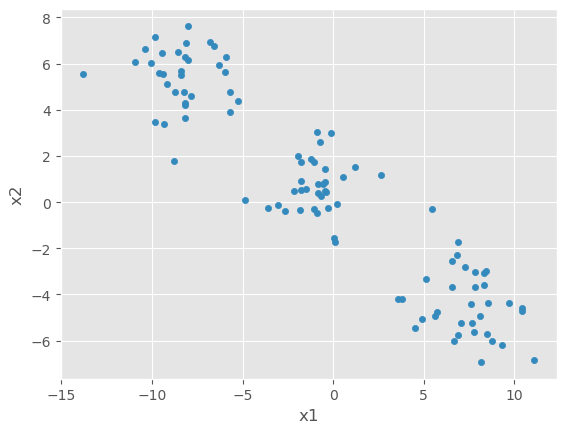

In [3]:
# Plot the scatter
df.plot.scatter(x='x1', y='x2');

In [2]:
# Let's prepare our X matrix
sc = StandardScaler()
X_sc = sc.fit_transform(df)

In [3]:
# import os
# os.environ['OMP_NUM_THREADS'] = '1'

In [4]:
# (THREAD) How many K here?
# I do: Fit a k-means clustering model
km = KMeans(n_clusters=3, random_state=42)
km.fit(X_sc)

KMeans(n_clusters=3, random_state=42)

After we fit our data, we can get our predicted labels from `model.labels_` and the center points`model.cluster_centers_`.

In [5]:
# Check out centroids
km.cluster_centers_

array([[-0.0338285 ,  0.03008366],
       [ 1.20438571, -1.19244188],
       [-1.16953211,  1.16144659]])

In [6]:
# Option 1: Class attribute
km.labels_

array([1, 0, 1, 0, 1, 2, 0, 2, 1, 0, 1, 0, 0, 0, 0, 0, 2, 1, 2, 0, 1, 1,
       1, 0, 1, 2, 0, 1, 0, 2, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 1, 2, 0, 2,
       2, 2, 1, 0, 2, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 1, 2, 2, 0, 0, 1, 2,
       2, 1, 0, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 2, 0, 0, 1, 0, 2, 2, 2,
       1, 1, 0, 0, 2, 2, 2, 1, 2, 2, 1, 0])

In [7]:
# Option 2: Predict
km.predict(X_sc)

array([1, 0, 1, 0, 1, 2, 0, 2, 1, 0, 1, 0, 0, 0, 0, 0, 2, 1, 2, 0, 1, 1,
       1, 0, 1, 2, 0, 1, 0, 2, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 1, 2, 0, 2,
       2, 2, 1, 0, 2, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 1, 2, 2, 0, 0, 1, 2,
       2, 1, 0, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 2, 0, 0, 1, 0, 2, 2, 2,
       1, 1, 0, 0, 2, 2, 2, 1, 2, 2, 1, 0])

In [9]:
# attach predicted cluster to original points
df['cluster'] = km.labels_
df.head()

,x1,x2,cluster
0,7.081642,-5.248171,1
1,-3.036735,-0.129646,0
2,5.117565,-3.323573,1
3,-1.807058,-0.335986,0
4,4.519789,-5.469635,1


In [11]:
km.cluster_centers_

array([[-0.0338285 ,  0.03008366],
       [ 1.20438571, -1.19244188],
       [-1.16953211,  1.16144659]])

In [10]:
# You do: Show me the mean values for x1 and x2 WITHIN EACH CLUSTER for our data. (thread)
df.groupby('cluster').mean()

,x1,x2
cluster,,
0,-0.808523,0.649190
1,7.423151,-4.492445
2,-8.358705,5.407417


### Visually verifying cluster labels

In [12]:
# Create a dataframe for cluster_centers (centroids)
centroids = pd.DataFrame(
    sc.inverse_transform(km.cluster_centers_),
    columns=['x1', 'x2']
)
centroids

,x1,x2
0,-0.808523,0.649190
1,7.423151,-4.492445
2,-8.358705,5.407417


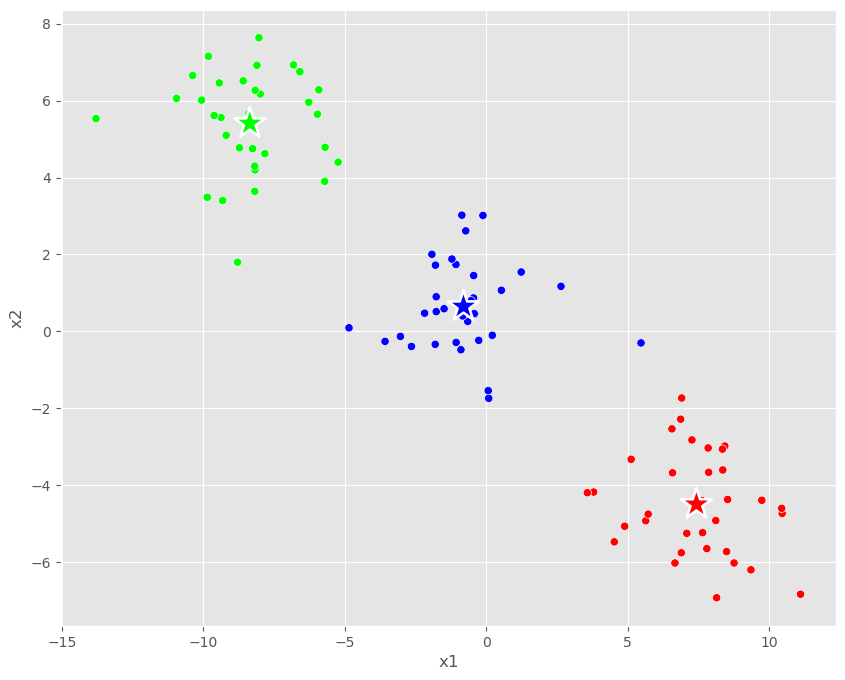

In [13]:
# Plot scatter by cluster / color, and centroids
plt.figure(figsize=(10,8))

sns.scatterplot(
    data=df,
    x='x1',
    y='x2',
    hue='cluster',
    palette='brg',
    legend=False
)

sns.scatterplot(
    data=centroids,
    x='x1',
    y='x2',
    hue=centroids.index,
    palette='brg',
    s=550,
    marker='*',
    legend=False
);

<a id='obj'></a>
## OPTIONAL: Understanding the objective function

---

In data science, you will typically see an **objective function** (the function to minimize or maximize) expressed mathematically. So, it is useful to get practice reading them.

#### Sum of Squared Errors

- In linear regression, logistic regression, and neural networks we often look for a prediction function $\hat{y}$ that minimizes the sum of squared errors (SSE) on a training dataset. 
- We start with:
    - $N$ data points. 
    - The $i$th data point consists of a vector of features $\mathbf{x}_i$ and a target $y_i$.
    - Before optimizing, we specify the exact form of $\hat{y}$. For example, we could define $\hat{y}(\mathbf{x}) := \beta_0 + \beta_1x_1 + \beta_2x_2$.

- Given that, here is the objective function for SSE:
$$\underset{\hat{y}}{\text{argmin}} \sum^N_{i=1} (y_i - \hat{y}(\mathbf{x}_i))^2$$

- $\underset{\hat{y}}{\text{argmin}}[SSE]$: We seek a function $\hat{y}$ that minimizes $SSE$.
    - Given the example definition of $\hat{y}$ above, this gives the parameters $\beta_0$, $\beta_1$, and $\beta_2$.


---

#### $K$-Means Clustering

- In $K$-means clustering, we look for a $K$-tuple of clusters that minimize the sum of squared distances (SSD) from each point to its cluster mean. We start with:
    - We are solving for the $K$ cluster means (vectors) given by $\mathbf{\mu} = (\mathbf{\mu_1}, \mathbf{\mu_2}, \cdots, \mathbf{\mu_K})$.
    - Derived from $\mathbf{\mu}$, the training dataset is partitioned into a set of clusters $\mathbb{C}$. The $i$th cluster is $\mathbb{C}_i$.
    - $||\mathbf{x} - \mathbf{\mu}_i ||$ is the squared distance between the vectors $\mathbf{x}$ and $\mathbf{\mathbf{\mu}_i}$. 

- Given that, here is the objective function for $K$-means clustering:
$$\underset{\mathbf{\mu}}{\text{argmin}} \sum^k_{i=1}\sum_{\mathbf{x} \in \mathbb{C_i}} ||\mathbf{x} - \mathbf{\mu}_i||$$

+ $\underset{\mathbf{\mu}}{\text{argmin}}[SSD]$: We seek the centroids $\mathbf{\mu}$ that minimize $SSD$.

<a id='sil'></a>

## Metrics: inertia and the silhouette score

---

In this section, we will look at the Silhouette Score -- one method of evaluating our results. Clustering metrics are most useful for (1) comparing to other clustering algorithms, and (2) warning us about bad clustering. As discussed above, since there is no definition for clustering, a metric cannot reliably tell us about whether the clustering is good. 

**A high score does not necessarily indicate good clustering.** Instead, it measures at best the difference between the metric and what our clustering algorithm optimized for.


**Inertia** -- sum of squared errors for each cluster. A low inertia = dense cluster.

> As the number of clusters $k$ increases, inertia decreases. 

**Silhouette Score** 

- Each point has a silhouette score.
- The score is high if is it:
    - similar to other points in its cluster (low **cohesion**) -AND-
    - dissimilar from points in neighboring clusters (high **separation**).

You know clustering is poor if many points have low scores. For example, notice that `dolphin` and `porpoise`, the last two points, could have been clustered better:

![](./assets/imgs/silhouette-wikipedIa.png)

Image from: Wikipedia, ["Silhouette (clustering)"](https://en.wikipedia.org/wiki/Silhouette_(clustering)).

The average Silhouette Score is the average of each point's score.

- **cohesion** = Average distance of points within clusters
- **separation** = Average distance of points in one cluster to points in other clusters

And it's calculated as:

$$s_i = \frac{b_i - a_i}{max\{a_i, b_i\}}$$

where:

* $a_i$ = Average distance from point $x_i$ to all other points **in the same cluster**.
* $b_i$ = Smallest mean distance from point $x_i$ to all points **in any other cluster**.

And the resulting silhouette score is the average of all the scores:

* -1 = Bad
* 0 = Meh
* 1 = Good

The silhouette score evaluates the viability of your clusters. It is a way to quantify the "cohesion" of local points to their clusters and the separation to other clusters.

### Easy to calculate Silhouette in Scikit-Learn

In [15]:
from sklearn.metrics import silhouette_score

silhouette_score(X_sc, km.labels_)

0.6856685892164016

### Programatically Inspecting $k$

Since we're familliar with gridsearch now, let's try it out!  Gridsearch is typically used for supervised learning with some scoring objective for optimizing parameters in terms of `best_model`.  We don't really care about the best model as much as we want to see how either inertia or silhouette score changes based on $k$.

We will write a basic process for exploring inertia and silhouette, that you can feel free to adapt to any other ML process you might write in Sklearn for doing custom scoring (using GridsearchCV is better for supervised learning because it has cross validation built-in!).

> Visually inspecting your clusters is vastly superior to relying on programatic parameter searching for an ideal cluster for most data.  You can also invent your own evalutation metrics other than inertia or silhoette.  The world is also bigger than k-means when it comes to cluster applications.  It's a great first stop in your journey of clustering.

In [16]:
scores = []
for k in range(2, 31):
    cl = KMeans(k)
    cl.fit(X_sc)
    inertia = cl.inertia_
    sil = silhouette_score(X_sc, cl.labels_)
    scores.append([k, inertia, sil])
    
score_df = pd.DataFrame(scores, columns=['k', 'inertia', 'silhouette'])

In [17]:
score_df.head()

,k,inertia,silhouette
0,2,56.111850,0.611233
1,3,15.485859,0.685669
2,4,12.586845,0.579278
3,5,10.392619,0.468386
4,6,8.778907,0.368773


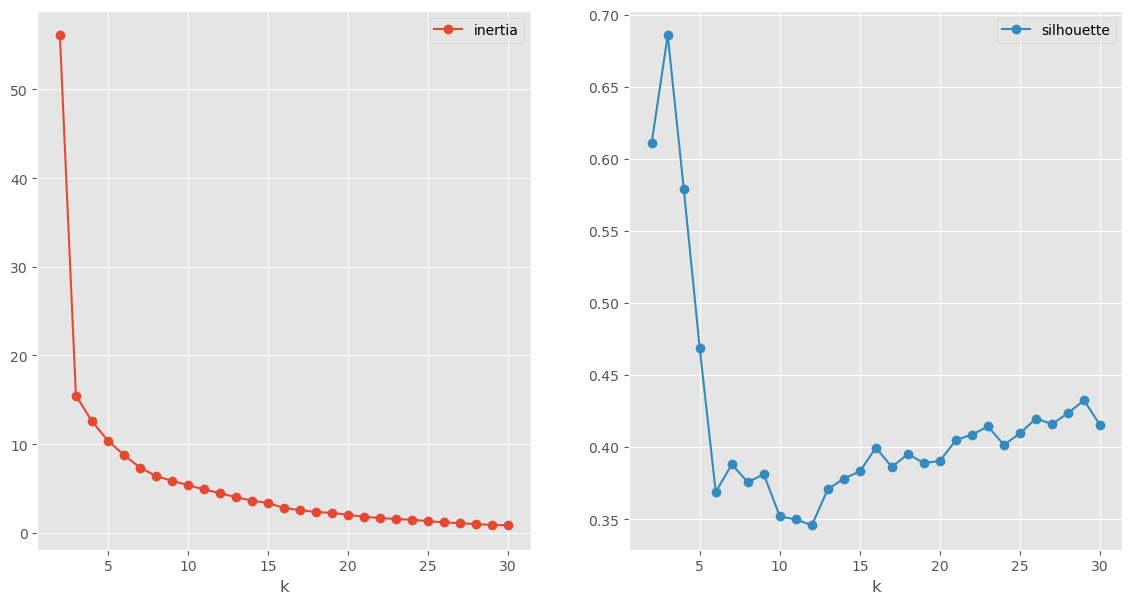

In [18]:
score_df.plot(x='k', subplots=True, layout=(1,2), figsize=(14,7), marker='o');

### Why is it called "silhouette" score?
![](./assets/imgs/silhouette.png)

In [ ]:
# install yellowbrick
# !conda install -y -c districtdatalabs yellowbrick 

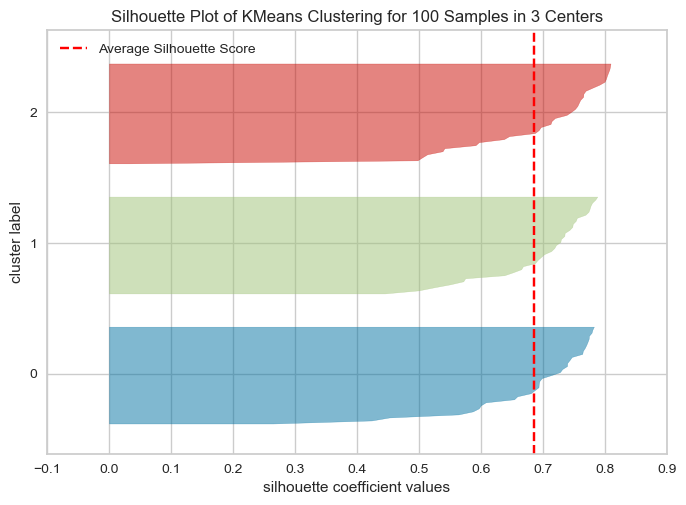

In [23]:
# Use yellowbrick to create a silhouette plot
from yellowbrick.cluster.silhouette import silhouette_visualizer

silhouette_visualizer(KMeans(3), X_sc, colors='yellowbrick');

<a name="conclusion"></a>
## Conclusion: K-Means tradeoffs

---

**K-Means:**
- Unsupervised clustering model
- Iteratively finds labels given k
- Easy to implement in sklearn
- Sensitive to shape, scale of data **(!!!)**
- Optimal k hard to evaluate

---

| Strengths | Weaknesses |
| -- | -- |
| k-Means is popular because it's simple and computationally efficient. | However, k-Means is highly scale dependent and isn't suitable for data of varying shapes and densities. |
| Easy to see results / intuitive. | Evaluating results is more subjective, requiring much more human evaluation than trusted metrics. |

### K-Means is sensitive to outliers

![](https://snag.gy/WFNMQY.jpg)

### K-Means is sensitive to centroid initialization

![](https://snag.gy/5sigCD.jpg)

# BONUS Exercise: Old Faithful
The classic Old Faithful dataset describes the durations of eruptions and the amount of waiting time since the last eruption for the Old Faithful geyser. Plot this data. Do you think this data could benefit from clustering? How many clusters are there? Repeat the steps of this lab for this dataset on your own.

In [24]:
geyser = pd.read_csv("./assets/datasets/geyser.csv")
geyser.head()

,duration,waiting
0,3.600,79
1,1.800,54
2,3.333,74
3,2.283,62
4,4.533,85
